In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 'full' # full
batch_size = 512
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_1.0_1024_full____2020_08_09_13_25_24_379625_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

- https://medium.com/fenwicks/tutorial-2-94-accuracy-on-cifar10-in-2-minutes-7b5aaecd9cdd
- https://colab.research.google.com/github/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb#scrollTo=n___bs94Rvm2
- https://www.tensorflow.org/tutorials/images/data_augmentation#using_tfimage
- https://github.com/tensorflow/models/pull/5906/files

In [100]:
import tensorflow_addons as tfa

In [262]:
def augment(image, label):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.25)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.flip_left_right(image)
    image = tf.image.random_hue(image, 0.1, seed=None)
    image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.4, maxval=.4)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (12,12), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image, label

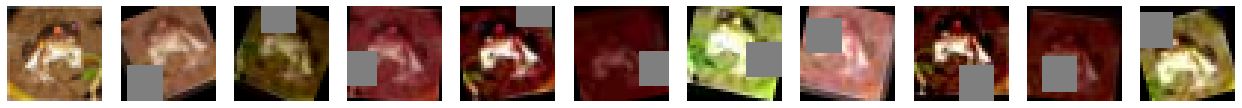

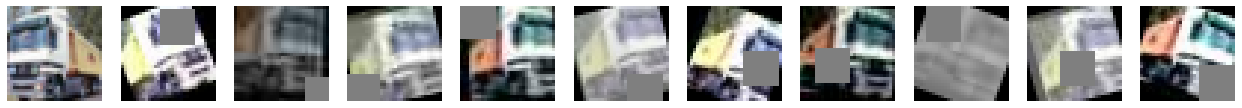

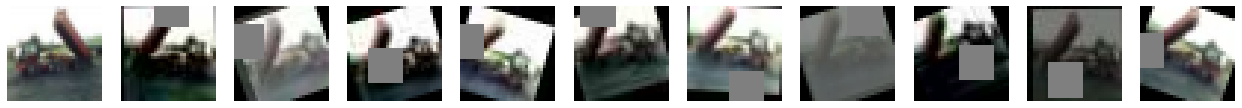

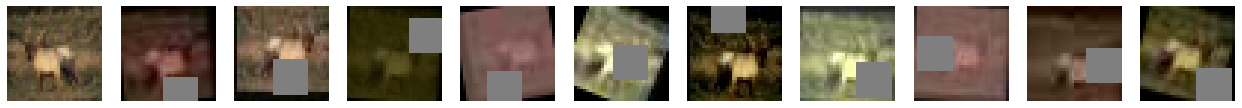

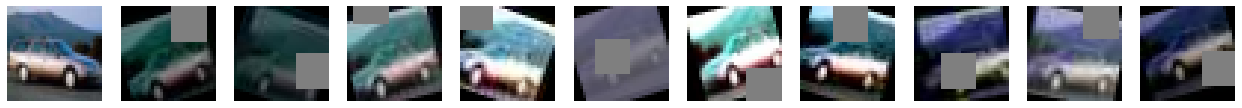

In [263]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(X_train[i])
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        ax.imshow(augment(X_train[i], Y_train[i])[0])
        ax.axis('off')

In [264]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled))
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [265]:
train_ds

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.uint8)>

In [266]:
for i in tqdm(iter(train_ds)):
    continue

### Build network

In [267]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [268]:
weight_decay = 1e-4
# https://github.com/RaptorMai/Cifar10-CNN-Keras/blob/master/Cifar_better.ipynb
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=dims))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(num_classes, activation='softmax'))

#model.summary()

In [269]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_60 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_61 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)      

In [270]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [271]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [272]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [273]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [274]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [275]:
x1, y1 = next(iter(train_ds))

In [276]:
x1.shape, y1.shape

(TensorShape([512, 32, 32, 3]), TensorShape([512, 10]))

In [277]:
##### didn't actually use augmentation!! $$$$$#######
history = model.fit(
    X_labeled,
    Y_labeled_one_hot,
    batch_size=batch_size,
    epochs=250,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/250
 1/79 [..............................] - ETA: 0s - loss: 4.6668 - accuracy: 0.0879

W0809 14:03:15.686039 139634549290816 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0119s vs `on_train_batch_end` time: 0.0274s). Check your callbacks.


79/79 [==============================] - 3s 44ms/step - loss: 3.5131 - accuracy: 0.2089 - val_loss: 2.3785 - val_accuracy: 0.1105
Epoch 2/250
79/79 [==============================] - 3s 39ms/step - loss: 2.8975 - accuracy: 0.2832 - val_loss: 2.4396 - val_accuracy: 0.1009
Epoch 3/250
79/79 [==============================] - 3s 38ms/step - loss: 2.5634 - accuracy: 0.3099 - val_loss: 2.4708 - val_accuracy: 0.1119
Epoch 4/250
79/79 [==============================] - 3s 38ms/step - loss: 2.3983 - accuracy: 0.3367 - val_loss: 2.4244 - val_accuracy: 0.1499
Epoch 5/250
79/79 [==============================] - 3s 38ms/step - loss: 2.3007 - accuracy: 0.3607 - val_loss: 2.3687 - val_accuracy: 0.1890
Epoch 6/250
79/79 [==============================] - 3s 37ms/step - loss: 2.2155 - accuracy: 0.3827 - val_loss: 2.1377 - val_accuracy: 0.2870
Epoch 7/250
79/79 [==============================] - 3s 39ms/step - loss: 2.1500 - accuracy: 0.4074 - val_loss: 1.9741 - val_accuracy: 0.3572
Epoch 8/250
79/79 

79/79 [==============================] - 3s 38ms/step - loss: 1.4638 - accuracy: 0.7503 - val_loss: 1.4602 - val_accuracy: 0.7452
Epoch 59/250
79/79 [==============================] - 3s 38ms/step - loss: 1.4552 - accuracy: 0.7521 - val_loss: 1.4515 - val_accuracy: 0.7444
Epoch 60/250
79/79 [==============================] - 3s 38ms/step - loss: 1.4468 - accuracy: 0.7603 - val_loss: 1.4283 - val_accuracy: 0.7482
Epoch 61/250
79/79 [==============================] - 3s 38ms/step - loss: 1.4481 - accuracy: 0.7590 - val_loss: 1.4437 - val_accuracy: 0.7327
Epoch 62/250
79/79 [==============================] - 3s 39ms/step - loss: 1.4386 - accuracy: 0.7608 - val_loss: 1.4479 - val_accuracy: 0.7456
Epoch 63/250
79/79 [==============================] - 3s 38ms/step - loss: 1.4524 - accuracy: 0.7574 - val_loss: 1.4392 - val_accuracy: 0.7441
Epoch 64/250
79/79 [==============================] - 3s 38ms/step - loss: 1.4345 - accuracy: 0.7626 - val_loss: 1.4200 - val_accuracy: 0.7624
Epoch 65/250

79/79 [==============================] - 2s 31ms/step - loss: 1.2832 - accuracy: 0.8470 - val_loss: 1.3217 - val_accuracy: 0.8155
Epoch 116/250
79/79 [==============================] - 2s 23ms/step - loss: 1.2824 - accuracy: 0.8464 - val_loss: 1.3241 - val_accuracy: 0.8145
Epoch 117/250
79/79 [==============================] - 2s 24ms/step - loss: 1.2874 - accuracy: 0.8469 - val_loss: 1.3228 - val_accuracy: 0.8143
Epoch 118/250
79/79 [==============================] - 3s 38ms/step - loss: 1.2778 - accuracy: 0.8510 - val_loss: 1.3285 - val_accuracy: 0.8133
Epoch 119/250
79/79 [==============================] - 3s 39ms/step - loss: 1.2770 - accuracy: 0.8485 - val_loss: 1.3427 - val_accuracy: 0.8122
Epoch 120/250
79/79 [==============================] - 3s 38ms/step - loss: 1.2786 - accuracy: 0.8515 - val_loss: 1.3273 - val_accuracy: 0.8114
Epoch 121/250
79/79 [==============================] - 3s 38ms/step - loss: 1.2776 - accuracy: 0.8510 - val_loss: 1.3111 - val_accuracy: 0.8192
Epoch 

Epoch 172/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1900 - accuracy: 0.8982 - val_loss: 1.2852 - val_accuracy: 0.8337
Epoch 173/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1898 - accuracy: 0.8975 - val_loss: 1.2797 - val_accuracy: 0.8369
Epoch 174/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1851 - accuracy: 0.9012 - val_loss: 1.2876 - val_accuracy: 0.8353
Epoch 175/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1807 - accuracy: 0.9017 - val_loss: 1.2694 - val_accuracy: 0.8349
Epoch 176/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1792 - accuracy: 0.9032 - val_loss: 1.2823 - val_accuracy: 0.8309
Epoch 177/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1809 - accuracy: 0.9043 - val_loss: 1.2799 - val_accuracy: 0.8328
Epoch 178/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1791 - accuracy: 0.9043 - val_loss: 1.2713 - val_accuracy:

In [279]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)

In [280]:
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 1s 4ms/step - loss: 1.2704 - accuracy: 0.8335


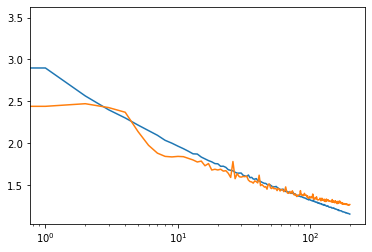

In [283]:
plt.semilogx(history.history['loss'])
plt.semilogx(history.history['val_loss'])

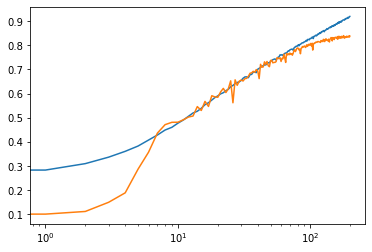

In [284]:
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])

In [287]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('batch_normalization_65').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 8, 8, 128)

In [288]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 17:18:56 2020 Finding Nearest Neighbors
Sun Aug  9 17:18:57 2020 Building RP forest with 15 trees
Sun Aug  9 17:19:03 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
Sun Aug  9 17:19:18 2020 Finished Nearest Neighbor Search
Sun Aug  9 17:19:21 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 17:19:55 2020 Finished embedding


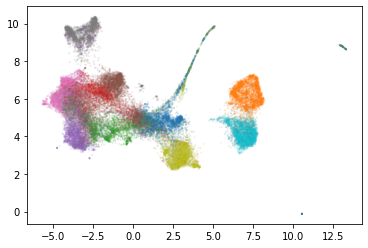

In [289]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)